# Swipe Gesture Classification

Train an LSTM model to classify swipe gestures:
- 0: Non-gesture
- 1: Swipe Left
- 2: Swipe Right

In [20]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Configuration

In [21]:
# Data paths - UPDATE THESE AFTER RE-COLLECTING DATA WITH NEW FEATURES
DATASET_PATHS = [
    'model/point_history_classifier/swipe_gesture_20260102_134712.csv',
    'model/point_history_classifier/swipe_gesture_20260103_032002.csv',
    'model/point_history_classifier/swipe_gesture_20260106_051821.csv',
]

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')

# Model paths
MODEL_SAVE_PATH = 'model/point_history_classifier/swipe_gesture_classifier_{}.keras'.format(current_time)
TFLITE_SAVE_PATH = 'model/point_history_classifier/swipe_gesture_classifier_{}.tflite'.format(current_time)

# Model parameters
NUM_CLASSES = 3  # Non-gesture, Swipe Left, Swipe Right
TIME_STEPS = 16  # History window size
FEATURES_PER_STEP = 16  # [x, y, dx, dy, angle, dtheta] + 5 fingertips × 2 coords

# Feature indices for reference:
# 0-1: palm_x, palm_y (normalized by scale)
# 2-3: dx, dy (velocity)
# 4-5: angle, dtheta (orientation)
# 6-7: thumb tip (x, y relative to palm)
# 8-9: index tip
# 10-11: middle tip
# 12-13: ring tip
# 14-15: pinky tip

## Load and Preprocess Data

In [22]:
# Load data
datasets = []
for path in DATASET_PATHS:
    data = np.atleast_2d(
        np.loadtxt(path, delimiter=',', dtype='float32')
    )
    datasets.append(data)

data = np.vstack(datasets)

# Expected columns: 1 (label) + TIME_STEPS * FEATURES_PER_STEP
expected_cols = 1 + TIME_STEPS * FEATURES_PER_STEP
print(f"Data shape: {data.shape}")
print(f"Expected: (samples, {expected_cols})")

if data.shape[1] != expected_cols:
    print(f"\n⚠️  WARNING: Data has {data.shape[1]} columns, expected {expected_cols}")
    print("Make sure you collected data with the new 16-feature format!")

# Split into labels and features
y = data[:, 0].astype(int)
X = data[:, 1:]

print(f"\nLabels: {y.shape}")
print(f"Features: {X.shape}")
print(f"\nClass distribution:")
for i in range(NUM_CLASSES):
    count = np.sum(y == i)
    print(f"  Class {i}: {count} samples ({100*count/len(y):.1f}%)")

Data shape: (4230, 257)
Expected: (samples, 257)

Labels: (4230,)
Features: (4230, 256)

Class distribution:
  Class 0: 2017 samples (47.7%)
  Class 1: 1168 samples (27.6%)
  Class 2: 1045 samples (24.7%)


In [23]:
# Reshape for LSTM: (samples, time_steps, features)
X_reshaped = X.reshape(-1, TIME_STEPS, FEATURES_PER_STEP)
print(f"Reshaped X: {X_reshaped.shape}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")

Reshaped X: (4230, 16, 16)

Train: (3384, 16, 16), Test: (846, 16, 16)


## Build LSTM Model

## Model Architecture Options

Choose one of the following architectures:
1. **TCN (Temporal Convolutional Network)** - Best balance of speed and accuracy for gestures
2. **Lightweight Transformer** - Best accuracy, slightly heavier
3. **Depthwise Separable Conv1D** - Lightest, good for edge devices
4. **SE-Conv1D** - Conv1D with channel attention

In [24]:
# ============================================================
# OPTION 1: TCN (Temporal Convolutional Network) - RECOMMENDED
# ============================================================
# Best for motion gestures - captures long-range dependencies with dilated convolutions

def residual_block(x, filters, kernel_size, dilation_rate):
    """TCN residual block with dilated causal convolution"""
    # Dilated causal convolution
    conv = tf.keras.layers.Conv1D(
        filters, kernel_size, 
        padding='causal', 
        dilation_rate=dilation_rate,
        activation='relu'
    )(x)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Dropout(0.2)(conv)
    
    conv = tf.keras.layers.Conv1D(
        filters, kernel_size,
        padding='causal',
        dilation_rate=dilation_rate,
        activation='relu'
    )(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Dropout(0.2)(conv)
    
    # Residual connection (match dimensions if needed)
    if x.shape[-1] != filters:
        x = tf.keras.layers.Conv1D(filters, 1, padding='same')(x)
    
    return tf.keras.layers.Add()([x, conv])

def build_tcn_model():
    inputs = tf.keras.Input(shape=(TIME_STEPS, FEATURES_PER_STEP))
    
    x = inputs
    # Dilated convolutions: 1, 2, 4, 8 for receptive field of 16
    for dilation_rate in [1, 2, 4, 8]:
        x = residual_block(x, filters=32, kernel_size=3, dilation_rate=dilation_rate)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

tcn_model = build_tcn_model()
tcn_model.summary()
print(f"\n📊 TCN Parameters: {tcn_model.count_params():,}")

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 16, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 16, 32)    │      1,568 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32)    │        128 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 16, 32)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 16, 32)    │      3,104 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32)    │        128 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 16, 32)    │        544 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 16, 32)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 16, 32)    │          0 │ conv1d_21[0][0],  │
│                     │                   │            │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 16, 32)    │      3,104 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32)    │        128 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 16, 32)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 16, 32)    │      3,104 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32)    │        128 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 16, 32)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 16, 32)    │          0 │ add_9[0][0],      │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 16, 32)    │      3,104 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32)    │        128 │ conv1d_24[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 16, 32)    │          0 │ batch_normalizat

 Total params: 26,019 (101.64 KB)

 Trainable params: 25,507 (99.64 KB)

 Non-trainable params: 512 (2.00 KB)


📊 TCN Parameters: 26,019


In [25]:
# ============================================================
# OPTION 2: Lightweight Transformer - Best Accuracy
# ============================================================
# Self-attention captures global temporal patterns effectively

def build_transformer_model(num_heads=4, ff_dim=64, num_blocks=2):
    inputs = tf.keras.Input(shape=(TIME_STEPS, FEATURES_PER_STEP))
    
    # Positional encoding (learnable)
    positions = tf.keras.layers.Embedding(TIME_STEPS, FEATURES_PER_STEP)(
        tf.range(TIME_STEPS)
    )
    x = inputs + positions
    
    # Transformer blocks
    for _ in range(num_blocks):
        # Multi-head self-attention
        attn_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=FEATURES_PER_STEP // num_heads,
            dropout=0.1
        )(x, x)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed-forward network
        ffn = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
        ffn = tf.keras.layers.Dropout(0.1)(ffn)
        ffn = tf.keras.layers.Dense(FEATURES_PER_STEP)(ffn)
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

transformer_model = build_transformer_model()
transformer_model.summary()
print(f"\n📊 Transformer Parameters: {transformer_model.count_params():,}")

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 16, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 16, 16)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 16)    │      1,088 │ add_13[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 16, 16)    │          0 │ add_13[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 16)    │         32 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 16, 64)    │      1,088 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 16, 64)    │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 16, 16)    │      1,040 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 16, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 16)    │         32 │ add_15[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 16, 16)    │      1,088 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 16, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 16)    │         32 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16, 64)    │      1,088 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 16, 64)    │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16, 16)    │      1,040 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 16, 16)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 16)    │         32 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,203 (28.14 KB)

 Trainable params: 7,203 (28.14 KB)

 Non-trainable params: 0 (0.00 B)


📊 Transformer Parameters: 7,203


In [26]:
# ============================================================
# OPTION 3: Depthwise Separable Conv1D - Lightest Model
# ============================================================
# MobileNet-style architecture - great for edge/mobile deployment

def build_depthwise_separable_model():
    inputs = tf.keras.Input(shape=(TIME_STEPS, FEATURES_PER_STEP))
    
    # Initial projection
    x = tf.keras.layers.Conv1D(32, 1, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Depthwise separable blocks
    for filters in [32, 64, 64]:
        # Depthwise convolution (spatial filtering per channel)
        x = tf.keras.layers.DepthwiseConv1D(
            kernel_size=3, 
            padding='same', 
            activation='relu'
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        # Pointwise convolution (channel mixing)
        x = tf.keras.layers.Conv1D(filters, 1, padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

dw_model = build_depthwise_separable_model()
dw_model.summary()
print(f"\n📊 Depthwise Separable Parameters: {dw_model.count_params():,}")

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 16, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 16, 32)         │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv1d_3              │ (None, 16, 32)         │           128 │
│ (DepthwiseConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 16, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 16, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 16, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv1d_4              │ (None, 16, 32)         │           128 │
│ (DepthwiseConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 16, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 16, 64)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv1d_5              │ (None, 16, 64)         │           256 │
│ (DepthwiseConv1D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 16, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_10     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,843 (46.26 KB)

 Trainable params: 11,203 (43.76 KB)

 Non-trainable params: 640 (2.50 KB)


📊 Depthwise Separable Parameters: 11,843


In [27]:
# ============================================================
# OPTION 4: SE-Conv1D (Squeeze-and-Excitation) 
# ============================================================
# Channel attention helps focus on important motion features

def squeeze_excitation_block(x, ratio=4):
    """Squeeze-and-Excitation block for channel attention"""
    filters = x.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling1D()(x)
    se = tf.keras.layers.Dense(filters // ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    se = tf.keras.layers.Reshape((1, filters))(se)
    return tf.keras.layers.Multiply()([x, se])

def build_se_conv1d_model():
    inputs = tf.keras.Input(shape=(TIME_STEPS, FEATURES_PER_STEP))
    
    x = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = squeeze_excitation_block(x)
    
    x = tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = squeeze_excitation_block(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = squeeze_excitation_block(x)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return tf.keras.Model(inputs, outputs)

se_model = build_se_conv1d_model()
se_model.summary()
print(f"\n📊 SE-Conv1D Parameters: {se_model.count_params():,}")

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 16, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 16, 32)    │      1,568 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32)    │        128 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 8)         │        264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 32)        │        288 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 32)     │          0 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 16, 32)    │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 16, 64)    │      6,208 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 16)        │      1,040 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      1,088 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 64)     │          0 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 16, 64)    │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 16, 64)    │          0 │ multiply_4[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 16, 64)    │     12,352 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 16)        │      1,040 │ global_average_p

 Total params: 27,755 (108.42 KB)

 Trainable params: 27,435 (107.17 KB)

 Non-trainable params: 320 (1.25 KB)


📊 SE-Conv1D Parameters: 27,755


In [28]:
# ============================================================
# SELECT YOUR MODEL HERE
# ============================================================
# Uncomment the model you want to train:

# model = tcn_model           # ⭐ RECOMMENDED - Best for motion gestures
# model = transformer_model   # Highest accuracy, slightly heavier
# model = dw_model            # Lightest - good for edge devices
# model = se_model            # Good balance with channel attention

# Default: TCN (best for swipe gesture recognition)
model = tcn_model

print(f"✅ Selected model: {model.name}")
print(f"📊 Total parameters: {model.count_params():,}")

✅ Selected model: functional_27
📊 Total parameters: 26,019


In [29]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Train Model

In [30]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH, 
        save_best_only=True, 
        monitor='val_accuracy',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=30, 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5, 
        patience=10, 
        verbose=1
    )
]

In [31]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/200
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6479 - loss: 1.2557
Epoch 1: val_accuracy improved from None to 0.84515, saving model to model/point_history_classifier/swipe_gesture_classifier_20260106_053255.keras

Epoch 1: finished saving model to model/point_history_classifier/swipe_gesture_classifier_20260106_053255.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7441 - loss: 0.7720 - val_accuracy: 0.8452 - val_loss: 0.3831 - learning_rate: 0.0010
Epoch 2/200
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8777 - loss: 0.3342
Epoch 2: val_accuracy improved from 0.84515 to 0.90898, saving model to model/point_history_classifier/swipe_gesture_classifier_20260106_053255.keras

Epoch 2: finished saving model to model/point_history_classifier/swipe_gesture_classifier_20260106_053255.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8762 - loss: 0.3447 - val_accuracy: 0.9090 - val_loss: 0.2350 - learning_rate: 0.0010
Epoch 3/200
 99/106 ━

## Evaluate Model

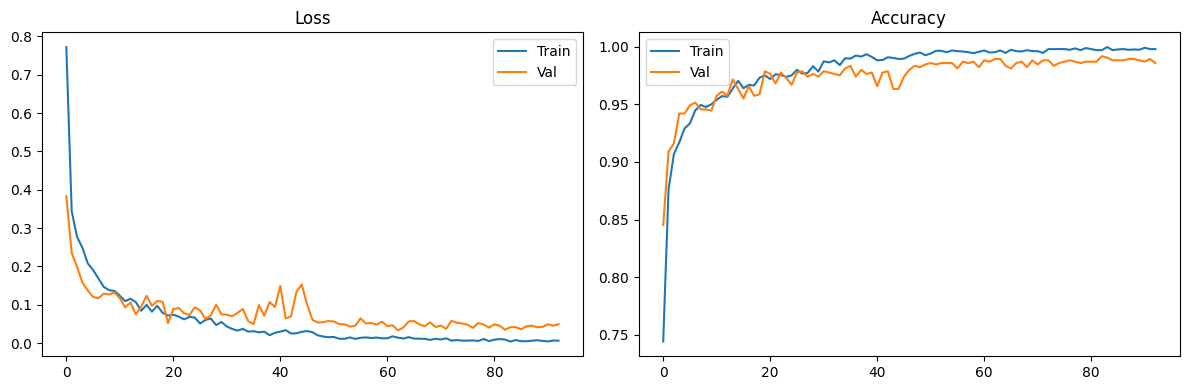

In [32]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Val')
ax1.set_title('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Val')
ax2.set_title('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [33]:
# Evaluation
y_pred = model.predict(X_test).argmax(axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-gesture', 'Swipe Left', 'Swipe Right']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

 Non-gesture       1.00      1.00      1.00       403
  Swipe Left       0.97      0.99      0.98       234
 Swipe Right       0.99      0.97      0.98       209

    accuracy                           0.99       846
   macro avg       0.99      0.99      0.99       846
weighted avg       0.99      0.99      0.99       846


Confusion Matrix:
[[403   0   0]
 [  1 231   2]
 [  0   6 203]]


## Convert to TFLite

In [34]:
# Load best model
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Convert to TFLite (standard ops only - fully compatible)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save
with open(TFLITE_SAVE_PATH, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {TFLITE_SAVE_PATH}")
print(f"Model size: {len(tflite_model) / 1024:.1f} KB")

INFO:tensorflow:Assets written to: /var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/tmpfd25hbwz/assets


INFO:tensorflow:Assets written to: /var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/tmpfd25hbwz/assets


Saved artifact at '/var/folders/hb/b1p7kpgj4s759vkptsfqzxzw0000gn/T/tmpfd25hbwz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 16, 16), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  13215370704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215379344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215367440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215368016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215371280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215369552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215370320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13494422416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215381648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215368784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13215380880: T

W0000 00:00:1767652449.768655 3371941 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767652449.768666 3371941 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


## Convert to TensorFlow.js

In [35]:
import os
import tensorflowjs as tfjs

TFJS_SAVE_DIR = '../frontend/public/models/swipe_gesture_tfjs'

# Create output directory
os.makedirs(TFJS_SAVE_DIR, exist_ok=True)

# Load the model (already loaded from previous cell, but reload to be safe)
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Convert directly using tensorflowjs Python API (works with Keras 3)
tfjs.converters.save_keras_model(model, TFJS_SAVE_DIR)

print(f"✅ TensorFlow.js model saved to: {TFJS_SAVE_DIR}")
# List output files
for f in os.listdir(TFJS_SAVE_DIR):
    filepath = os.path.join(TFJS_SAVE_DIR, f)
    size = os.path.getsize(filepath) / 1024
    print(f"  - {f} ({size:.1f} KB)")

failed to lookup keras version from the file,
    this is likely a weight only file
✅ TensorFlow.js model saved to: ../frontend/public/models/swipe_gesture_tfjs
  - model.json (30.7 KB)
  - group1-shard1of1.bin (101.6 KB)


## Test TFLite Model

In [36]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=TFLITE_SAVE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Output shape:", output_details[0]['shape'])

Input shape: [ 1 16 16]
Output shape: [1 3]


/Users/dikaizm/Documents/PROGRAMMING/ml-ai/binarimaji-signage/hand-gesture-recognition-mediapipe/.venv/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [37]:
# Test on a sample
test_sample = X_test[0:1]
interpreter.set_tensor(input_details[0]['index'], test_sample)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])

print(f"Predicted: {output.argmax()}")
print(f"Actual: {y_test[0]}")
print(f"Probabilities: {output[0]}")

Predicted: 2
Actual: 2
Probabilities: [9.185034e-22 4.514362e-10 1.000000e+00]
